In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 
# 노트북에서 plot 바로 가능하게
from sklearn.model_selection import train_test_split

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_LIB = '/content/drive/MyDrive/ML/Lung Cancer Segmentation/2d_images/'
MASK_LIB = '/content/drive/MyDrive/ML/Lung Cancer Segmentation/2d_masks/'
IMG_HEIGHT, IMG_WIDTH = 256, 256
SEED = 42

In [ ]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.tif']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
print(x_data.shape)

for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32') # unchanged -> alpha 채널까지 읽어드림
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = np.clip(im, -600-750, -600+750) # CT windowing
    im = (im-np.min(im)) / (np.max(im) - np.min(im)) # data normalization
    print('x ', i)
    x_data[i] = im
    
y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    print('y ', i)
    y_data[i] = im


(267, 256, 256)
x  0
x  1
x  2
x  3
x  4
x  5
x  6
x  7
x  8
x  9
x  10
x  11
x  12
x  13
x  14
x  15
x  16
x  17
x  18
x  19
x  20
x  21
x  22
x  23
x  24
x  25
x  26
x  27
x  28
x  29
x  30
x  31
x  32
x  33
x  34
x  35
x  36
x  37
x  38
x  39
x  40
x  41
x  42
x  43
x  44
x  45
x  46
x  47
x  48
x  49
x  50
x  51
x  52
x  53
x  54
x  55
x  56
x  57
x  58
x  59
x  60
x  61
x  62
x  63
x  64
x  65
x  66
x  67
x  68
x  69
x  70
x  71
x  72
x  73
x  74
x  75
x  76
x  77
x  78
x  79
x  80
x  81
x  82
x  83
x  84
x  85
x  86
x  87
x  88
x  89
x  90
x  91
x  92
x  93
x  94
x  95
x  96
x  97
x  98
x  99
x  100
x  101
x  102
x  103
x  104
x  105
x  106
x  107
x  108
x  109
x  110
x  111
x  112
x  113
x  114
x  115
x  116
x  117
x  118
x  119
x  120
x  121
x  122
x  123
x  124
x  125
x  126
x  127
x  128
x  129
x  130
x  131
x  132
x  133
x  134
x  135
x  136
x  137
x  138
x  139
x  140
x  141
x  142
x  143
x  144
x  145
x  146
x  147
x  148
x  149
x  150
x  151
x  152
x  153
x  154
x  155
x 

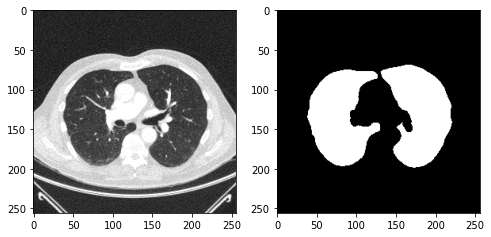

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [ ]:
print(x_data.shape)
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
print(x_data.shape)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)
print(len(x_train))
print(len(x_val))

(267, 256, 256)
(267, 256, 256, 1)
133
134


In [ ]:
''' 
dice coef 손실함수 (custom) 
DSC = 2|X∩Y| / |X| + |Y|
라벨링된 영역과 예측한 영역이 정확히 같다면, 1이되며 그렇지 않을 경우에는 0이 된다
'''
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [ ]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size = (3,3), activation='relu', padding = 'same')(input_layer)
l = MaxPool2D(strides = (2,2))(c1) # 기본 pool size가 2x2
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding = 'same')(l)
l = MaxPool2D(strides = (2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides = (2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)

l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 1168        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        rotation_range=10,
                        zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        rotation_range=10,
                        zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

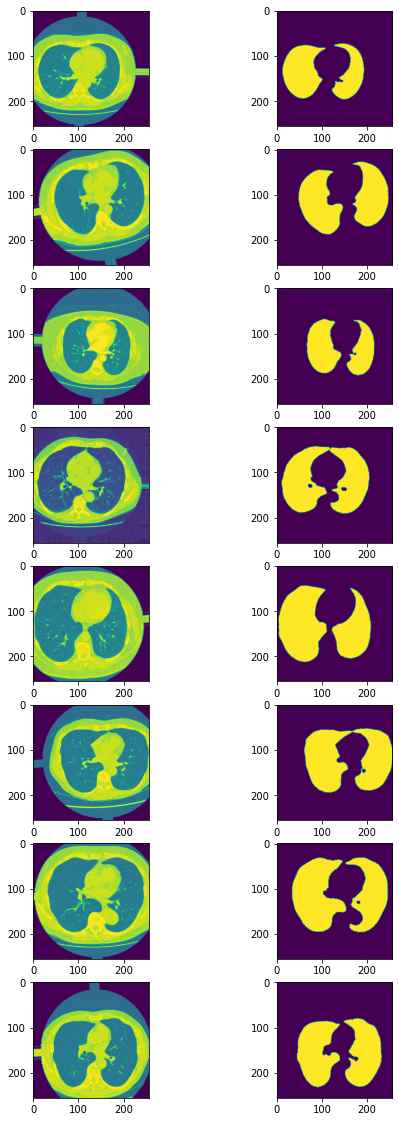

In [ ]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [ ]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [ ]:
weight_saver = ModelCheckpoint('lung.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [ ]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=20, verbose=2,
                           callbacks = [weight_saver, annealer])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
200/200 - 299s - loss: 0.3861 - dice_coef: 0.4370 - val_loss: 0.2584 - val_dice_coef: 0.5692
Epoch 2/20
200/200 - 296s - loss: 0.1583 - dice_coef: 0.7634 - val_loss: 0.1635 - val_dice_coef: 0.8403
Epoch 3/20
200/200 - 302s - loss: 0.0882 - dice_coef: 0.8967 - val_loss: 0.1383 - val_dice_coef: 0.8692
Epoch 4/20
200/200 - 299s - loss: 0.0761 - dice_coef: 0.9138 - val_loss: 0.1128 - val_dice_coef: 0.8949
Epoch 5/20
200/200 - 300s - loss: 0.0737 - dice_coef: 0.9171 - val_loss: 0.1361 - val_dice_coef: 0.8814
Epoch 6/20
200/200 - 300s - loss: 0.0653 - dice_coef: 0.9270 - val_loss: 0.1508 - val_dice_coef: 0.8769
Epoch 7/20
200/200 - 298s - loss: 0.0650 - dice_coef: 0.9275 - val_loss: 0.1717 - val_dice_coef: 0.8641
Epoch 8/20
200/200 - 298s - loss: 0.0620 - dice_coef: 0.9307 - val_loss: 0.1498 - val_dice_coef: 0.8735
Epoch 9/20
200/200 - 300s - loss: 0.0613 - dice_coef: 0.9319 - val_loss: 0.1531 - val_dice_coef: 0.8755
Epoch 10/20
200/200 - 298s - loss: 0.0610 - dice_coef: 0.9322 - 

In [ ]:
model.load_weights('lung.h5')

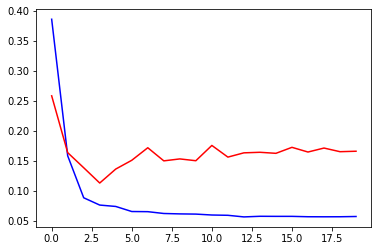

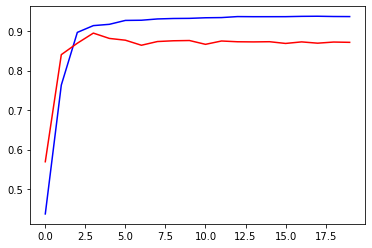

In [ ]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

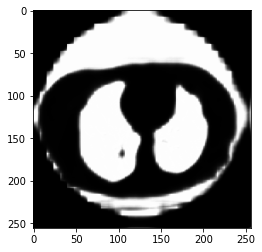

In [ ]:
plt.imshow(model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

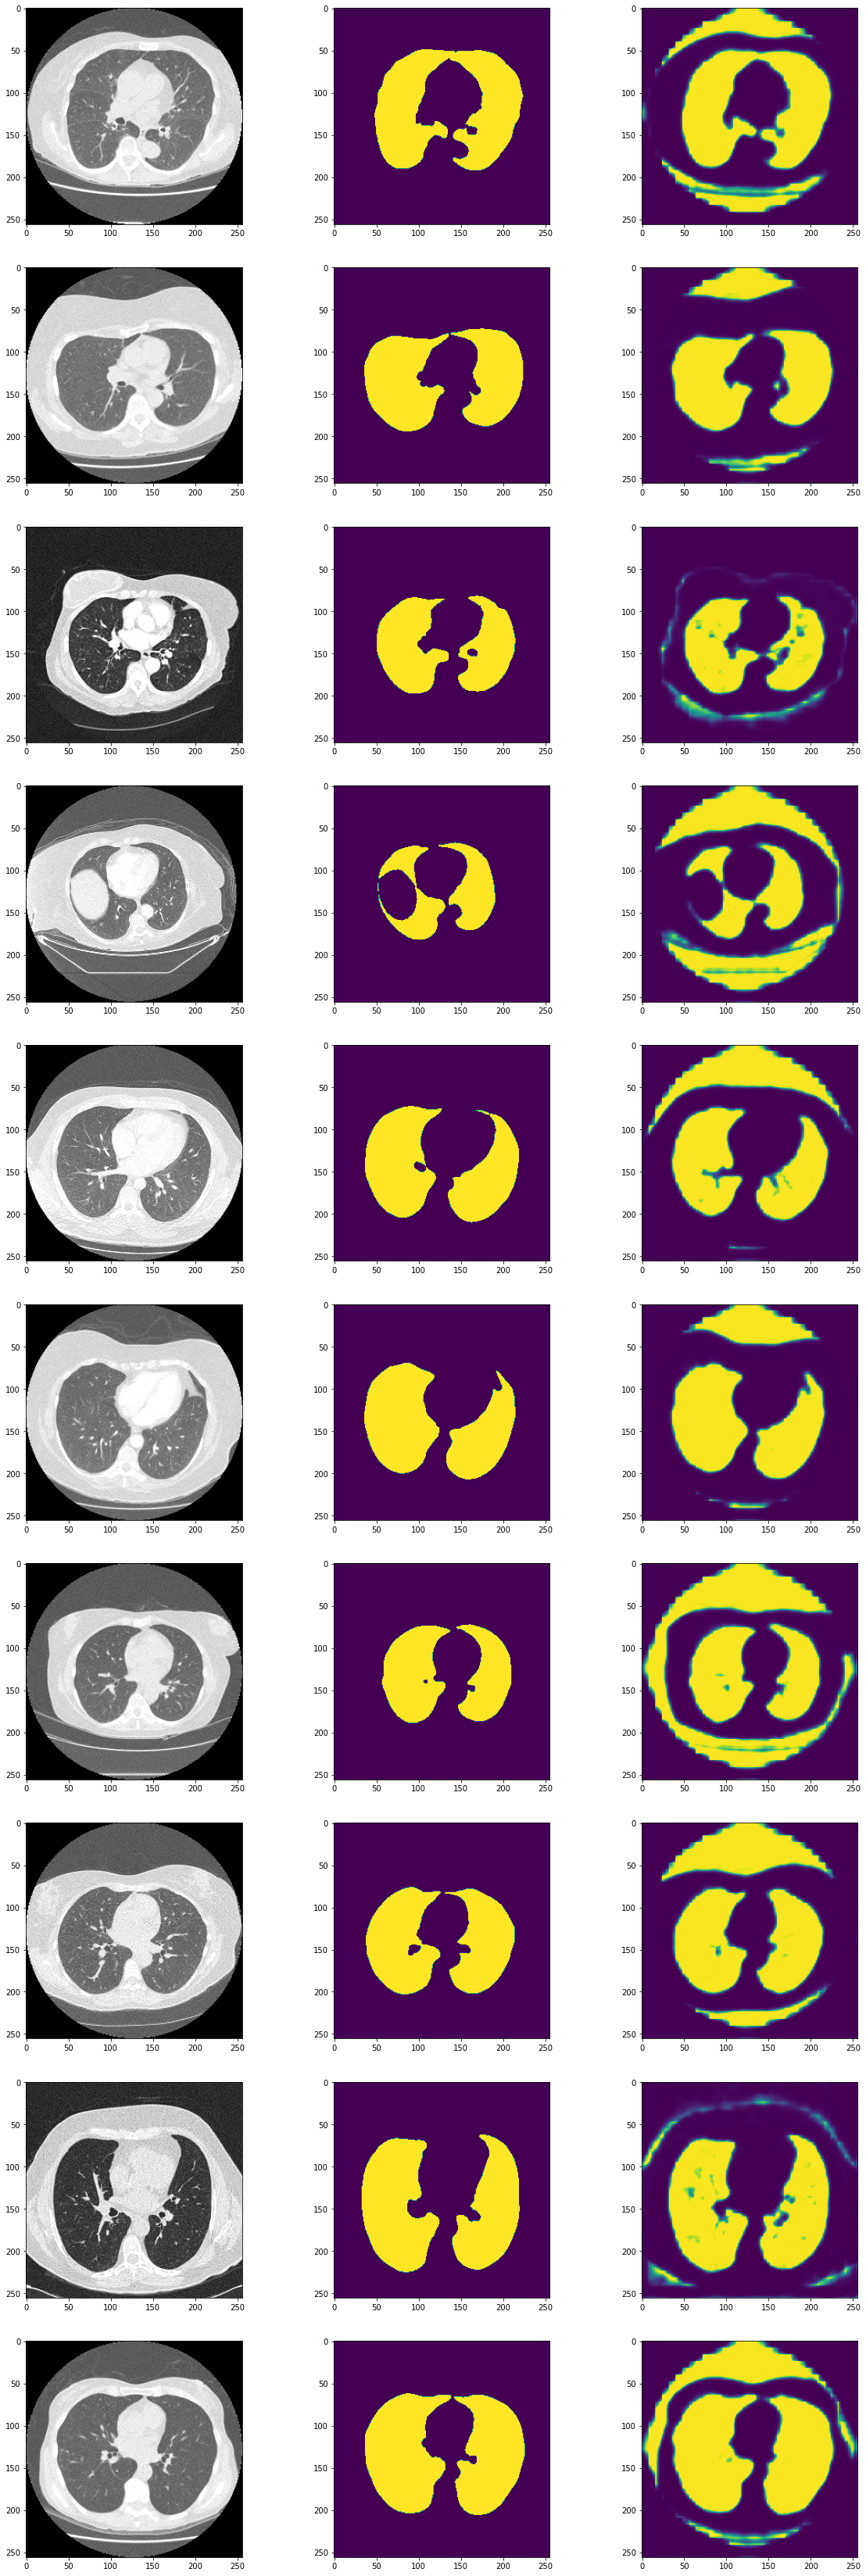

In [ ]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(10,3,figsize=(20,60))
for i in range(10):
  ax[i][0].imshow(x_val[i,:,:,0], cmap='gray')
  ax[i][1].imshow(y_val[i,:,:,0])
  ax[i][2].imshow(y_hat[i,:,:,0])